In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
file_path = "data/noemoticon_with_header.csv"
df = pd.read_csv(file_path, encoding="latin1")

from textpreprocesshelper import TextPreprocessHelper, NumberProcessor
helper = TextPreprocessHelper()

# **文本预处理**
df["text"] = df["text"].apply(helper.denoise_text)
df["text"] = df["text"].apply(helper.expand_contractions)
df["text"] = df["text"].apply(helper.remove_mentions_and_emails)

c:\Users\Zhou&Wan\Documents\GitHub\Text-Mining\groupproject\textpreprocesshelper.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [23]:
label_mapping = {0: 0, 4: 1} #把原始的 0/4 映射成 0/1，实现 二分类任务
df["polarity"] = df["polarity"].map(label_mapping)

In [24]:
df["tokens"] = df["text"].apply(word_tokenize) #base on the experience of 1-simple-classifier, directly use nftk's word_tokenize

In [25]:
counter = Counter()
for tokens in df["tokens"]:  
    counter.update(tokens)

In [26]:
def check_low_high_frequence_words(low_freq_threshold=5) :
    low_freq_words = [word for word, freq in counter.items() if freq <= low_freq_threshold]
    print(f"Total unique words: {len(counter)}")
    print(f"Words appearing ≤ {low_freq_threshold} times: {len(low_freq_words)}")
    high_freq_words = len(counter) - len(low_freq_words)
    print(f"Words appearing > {low_freq_threshold} times: {high_freq_words}")
    print(f"Percentage of low-frequency words: {len(low_freq_words) / len(counter) * 100:.2f}%")

In [27]:
check_low_high_frequence_words(5)

Total unique words: 429952
Words appearing ≤ 5 times: 379663
Words appearing > 5 times: 50289
Percentage of low-frequency words: 88.30%


In [28]:
check_low_high_frequence_words(10)

Total unique words: 429952
Words appearing ≤ 10 times: 396433
Words appearing > 10 times: 33519
Percentage of low-frequency words: 92.20%


In [29]:
check_low_high_frequence_words(20)

Total unique words: 429952
Words appearing ≤ 20 times: 407627
Words appearing > 20 times: 22325
Percentage of low-frequency words: 94.81%


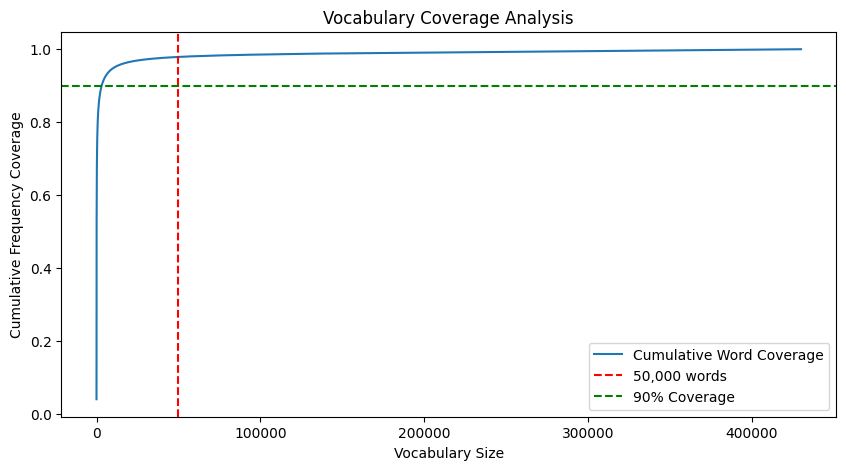

In [31]:
import matplotlib.pyplot as plt
# 获取所有词汇的频率，并按出现次数降序排序
word_freqs = sorted(counter.values(), reverse=True)

# 计算累积覆盖率
total_words = sum(word_freqs)  # 总词频
cumulative_freqs = np.cumsum(word_freqs) / total_words  # 计算累计覆盖率

# 绘制词频累积分布图
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(word_freqs) + 1), cumulative_freqs, label="Cumulative Word Coverage")
plt.axvline(50000, color='r', linestyle='dashed', label="50,000 words")
plt.axhline(0.9, color='g', linestyle='dashed', label="90% Coverage")
plt.xlabel("Vocabulary Size")
plt.ylabel("Cumulative Frequency Coverage")
plt.legend()
plt.title("Vocabulary Coverage Analysis")
plt.show()

In [32]:
max_vocab_size = 50000  
# 限制词汇表大小，防止低频词占用太多空间 
# based on 
#   1. Words appearing > 5 times: 50289 
#   2. Percentage of low-frequency words: 88.30%
word2idx = {"<PAD>": 0, "<UNK>": 1}  # 预留特殊标记
for i, (word, freq) in enumerate(counter.most_common(max_vocab_size - 2), start=2):
    word2idx[word] = i

In [33]:
# **将文本转换为索引**
def tokens_to_ids(tokens, word2idx):
    return [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]

df["token_ids"] = df["tokens"].apply(lambda x: tokens_to_ids(x, word2idx))

In [34]:
# **训练/测试数据集划分**
train_x, test_x, train_y, test_y = train_test_split(
    df["token_ids"].tolist(), df["polarity"].tolist(),
    test_size=0.2, random_state=34, stratify=df["polarity"]
)

In [35]:
# **PyTorch Dataset**
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(t, dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [36]:
# **Padding Collate Function**
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=word2idx['<PAD>'])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded.to(device), labels.to(device)

In [37]:
# **创建 DataLoader**
batch_size = 64
train_dataset = TextDataset(train_x, train_y)
test_dataset = TextDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [38]:
# **构建 RNN 模型**
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=word2idx['<PAD>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

In [39]:
# **超参数**
embed_dim = 128
hidden_dim = 64
num_classes = 2

In [40]:
# **初始化模型**
model = RNNClassifier(vocab_size=len(word2idx), embed_dim=embed_dim, hidden_dim=hidden_dim, num_classes=num_classes)
model.to(device)

# **损失函数 & 优化器**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# **训练模型**
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_texts, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_texts)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 20000/20000 [06:28<00:00, 51.47it/s] 


Epoch 1, Loss: 0.4840


Epoch 2/5: 100%|██████████| 20000/20000 [06:54<00:00, 48.25it/s] 


Epoch 2, Loss: 0.3770


Epoch 3/5: 100%|██████████| 20000/20000 [07:40<00:00, 43.44it/s] 


Epoch 3, Loss: 0.3510


Epoch 4/5: 100%|██████████| 20000/20000 [07:16<00:00, 45.78it/s] 


Epoch 4, Loss: 0.3316


Epoch 5/5: 100%|██████████| 20000/20000 [07:19<00:00, 45.52it/s] 

Epoch 5, Loss: 0.3149


In [42]:
# **评估模型**
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_texts, batch_labels in test_loader:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)

        outputs = model(batch_texts)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# **计算 Precision, Recall, F1-score**
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83    160000
    Positive       0.83      0.84      0.84    160000

    accuracy                           0.83    320000
   macro avg       0.84      0.83      0.83    320000
weighted avg       0.84      0.83      0.83    320000

